## 0.0 IMPORTS

In [1]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
import datetime

from IPython.display import Image

### 0.1 Helper functions

### 0.2 Load Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv' , low_memory = False)
df_store_raw = pd.read_csv('data/store.csv' , low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw , how='left' , on='Store')

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
37458,664,7,2015-06-28,0,0,0,0,0,0,d,c,1680.0,10.0,2005.0,0,NaN,NaN,NaN


## 1.0. PASSO 01 - DESCRICAO DOS DADOS


In [4]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase , cols_old))

#rename

df1.columns = cols_new

### 1.2 Data Dimensions

In [6]:
print('Number of Rows:{}'.format(df1.shape[0]))
print('Number of Cols:{}'.format(df1.shape[1]))

Number of Rows:1017209
Number of Cols:18


### 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [9]:
#competition_distance    
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)


#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)
                            
#promo2_since_week   
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

#promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#promo_interval

month_map = {1 : 'Jan', 2 : 'Feb', 3 : 'Mar', 4 : 'Apr', 5 : 'May', 6 : 'Jun', 7 : 'Jul', 8 : 'Aug', 9 : 'Sep', 10 : 'Oct', 11 : 'Nov', 12 : 'Dec'}

df1['promo_interval'].fillna(0 , inplace =True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']= df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6 Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

### 1.7 Descriptive Statical

In [12]:
num_attributes = df1.select_dtypes(include = ['int64' , 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64' , 'float64','datetime64[ns]'])

#### 1.7.1 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T


# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame(num_attributes.apply( min ) ).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())) .T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())) .T


#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max', 'range','mean','median','std','skew','kurtosis']

In [14]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


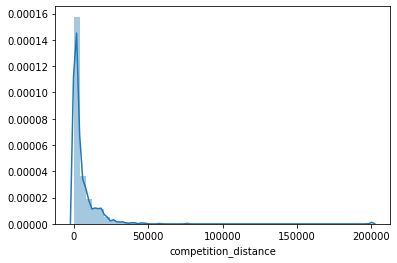

In [15]:
sns.distplot( df1['competition_distance'] )

#### 1.7.2 Categorical Attributes

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

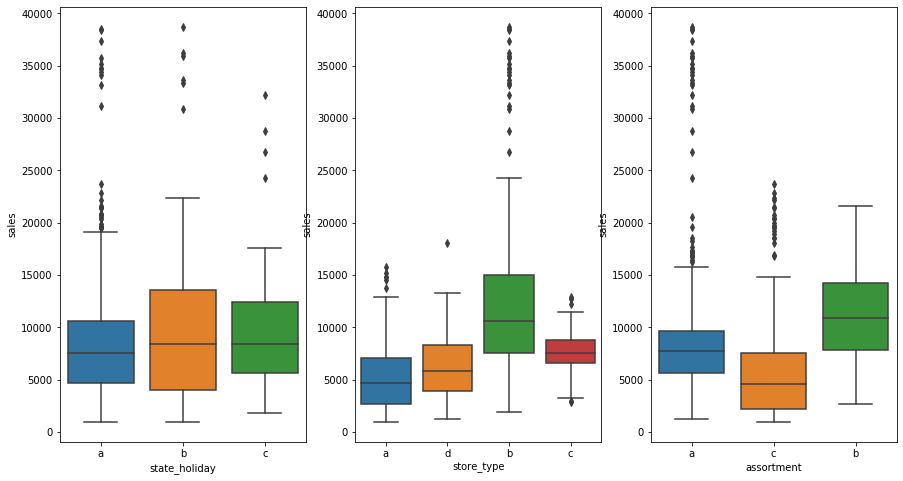

In [17]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(15,8))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2.0 PASSO 02 - FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

###  Mapa Mental de Hipoteses

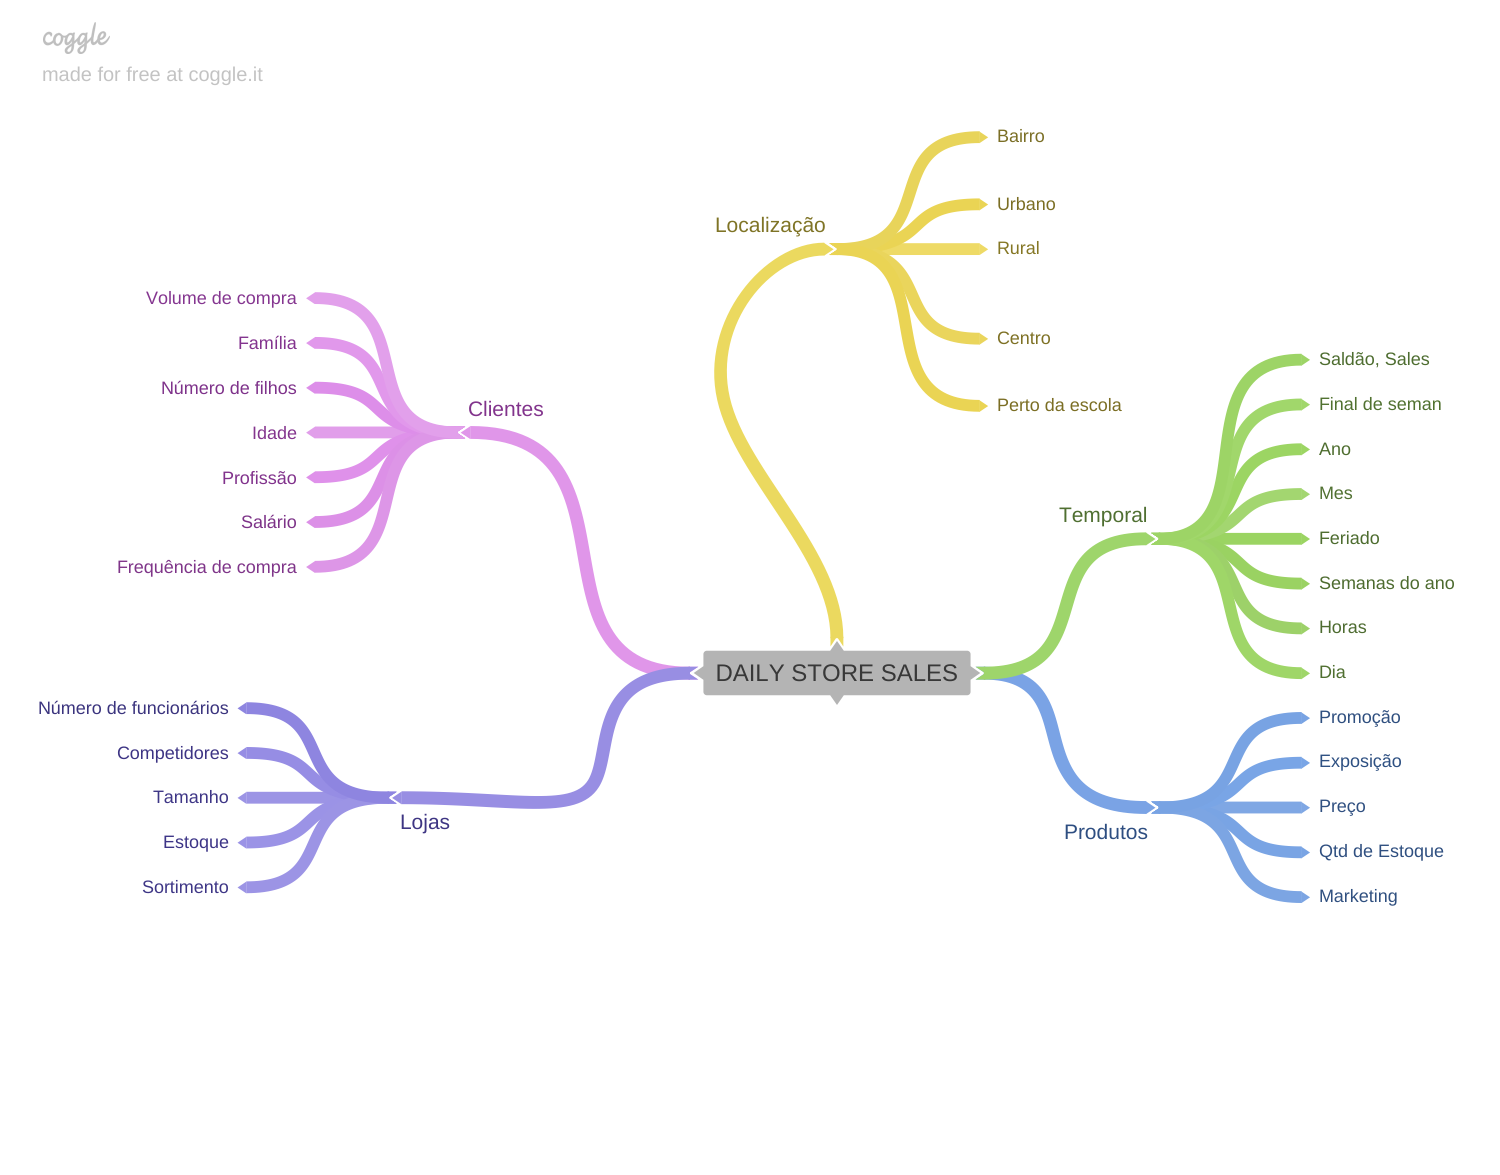

In [19]:
Image ('img/mindmaphypoteses.png')

### 2.1 Criacao das Hipotese

#### 2.1.2 Hipotese Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com maior sortimento deveria vender mais.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


#### 2.1.2 Hipotese Produto

**1.** Lojas que investem mais em Marketing deveria vender mais.

**2.** Lojas com maior exposicao dos produtos nas vitrines deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


#### 2.1.3 Hipotese Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 - Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

## competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

## 3.0 PASSO 03 - FILTRAGEM DAS VARIÁVEIS

In [21]:
df3 = df2.copy()

### 3.1 Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [23]:
df3.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


### 3.2 Seleção das colunas 

In [24]:
drop_cols = ['customers','open', 'month_map','promo_interval']
df3 = df3.drop(drop_cols ,axis =1)

## 4.0 PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [25]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Response Variable

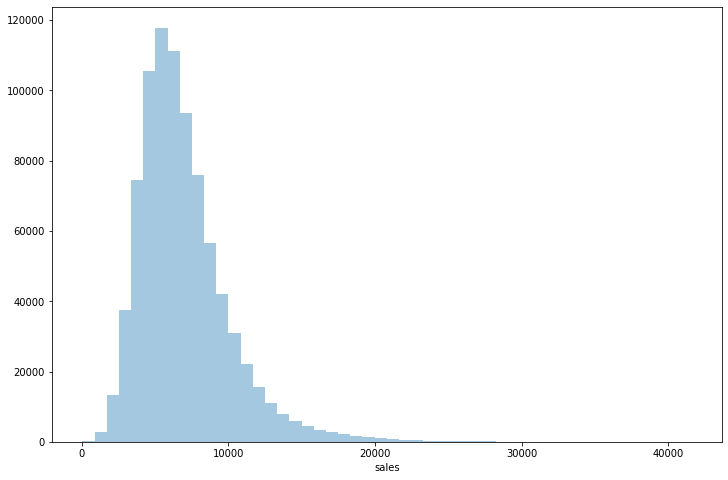

In [26]:
plt.figure(figsize=(12,8))
sns.distplot(df4['sales'], kde =False)


#### 4.1.2 Numerical Variable

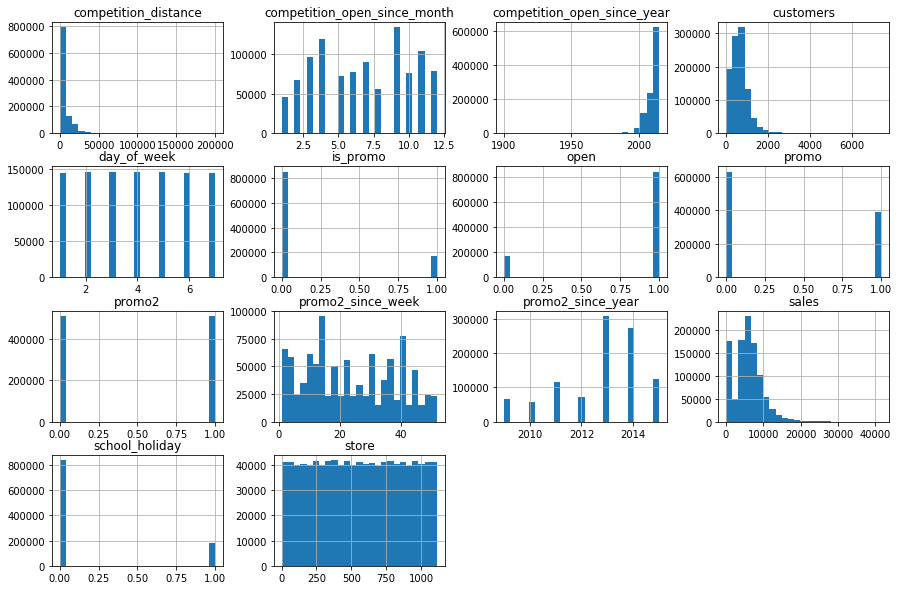

In [27]:
num_attributes.hist(bins =25,figsize=(15, 10));

#### 4.1.3 Categorical Variable

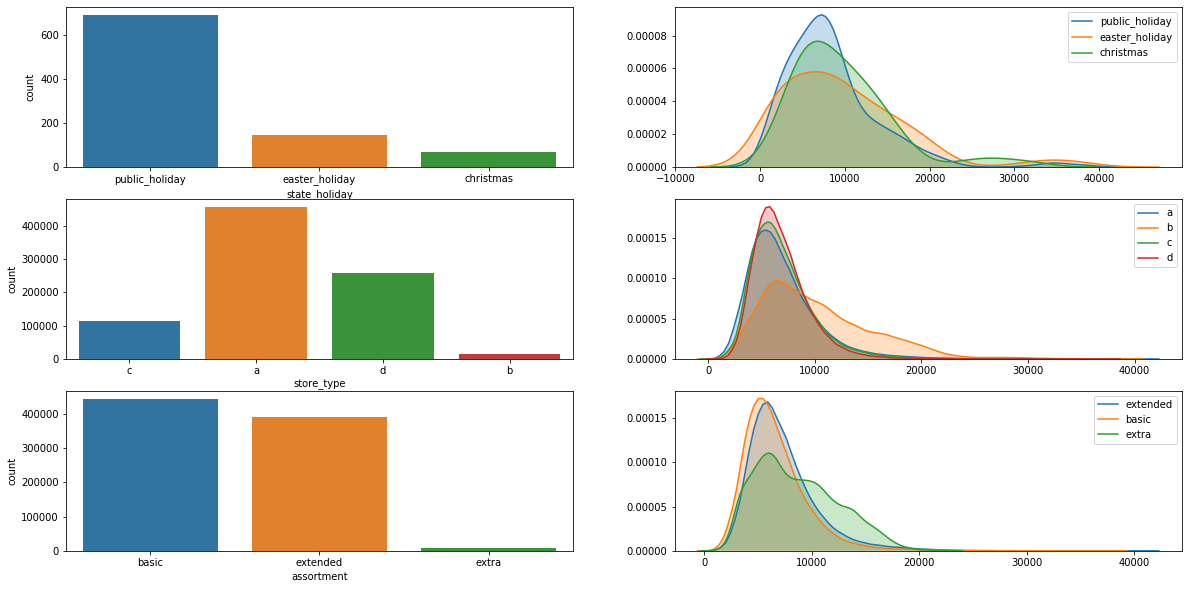

In [28]:
plt.figure(figsize=(20,10))

# state holiday
plt.subplot( 3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( aux['state_holiday'])

plt.subplot( 3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# store type
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'])

plt.subplot( 3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'])

plt.subplot( 3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
plt.legend()

### 4.2 Análise Bivariada


#### Hipotese 1. Lojas com maior sortimentos deveriam vender mais.

**FALSA!** Lojas com MAIOR SORTIMENTO vendem MENOS.

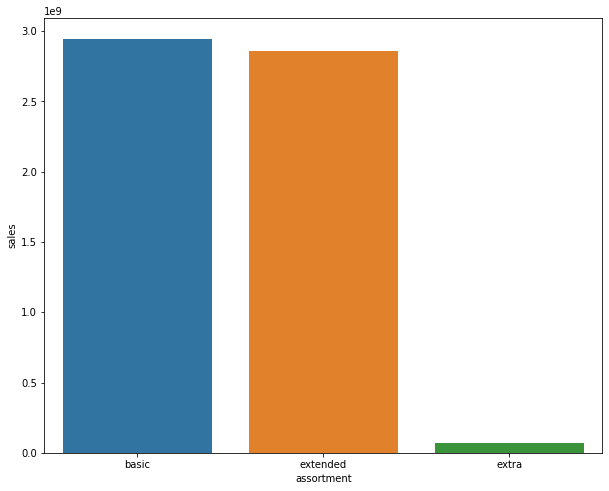

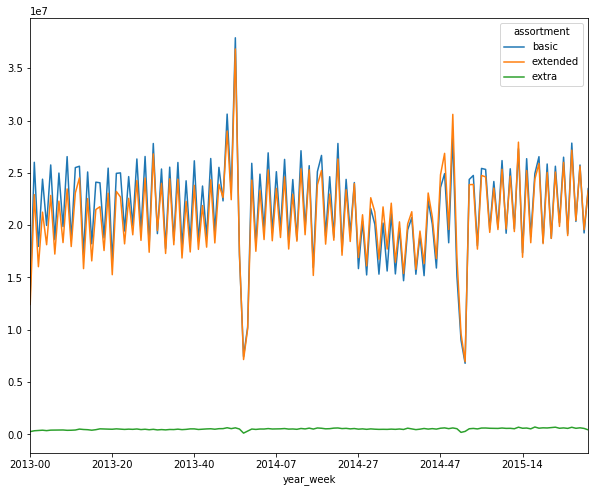

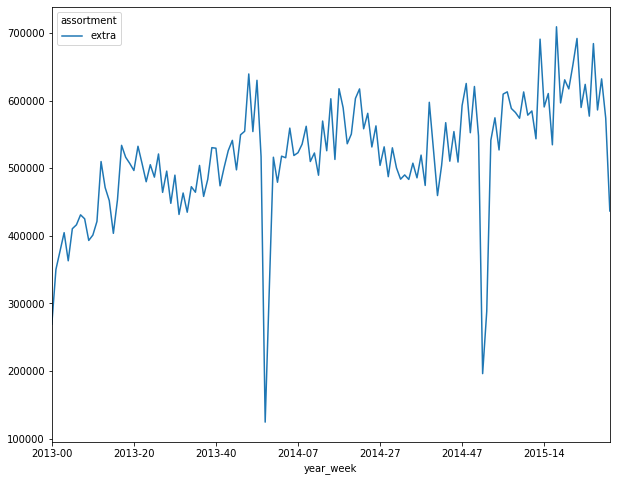

In [29]:
aux1 = df4[['assortment' , 'sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(x = 'assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment' , 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values='sales').plot(figsize=(10,8))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot(figsize=(10,8))

#### Hipótese 2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA!** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

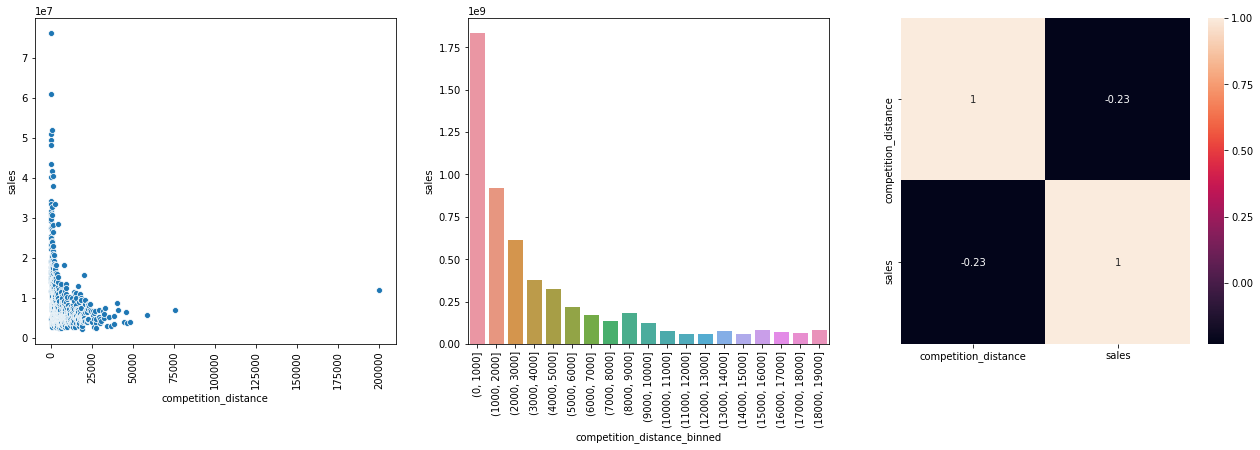

In [30]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.figure( figsize=(22,6))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance' , y='sales', data=aux1)
plt.xticks( rotation=90 )

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot =True);


In [31]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
348,5070.0,9058814,"(5000, 6000]"
286,3700.0,5453808,"(3000, 4000]"
357,5260.0,5229014,"(5000, 6000]"
366,5440.0,4835283,"(5000, 6000]"


#### Hipótese 3. Lojas com competidores à mais tempo deveriam vendem mais.

**FALSA!** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

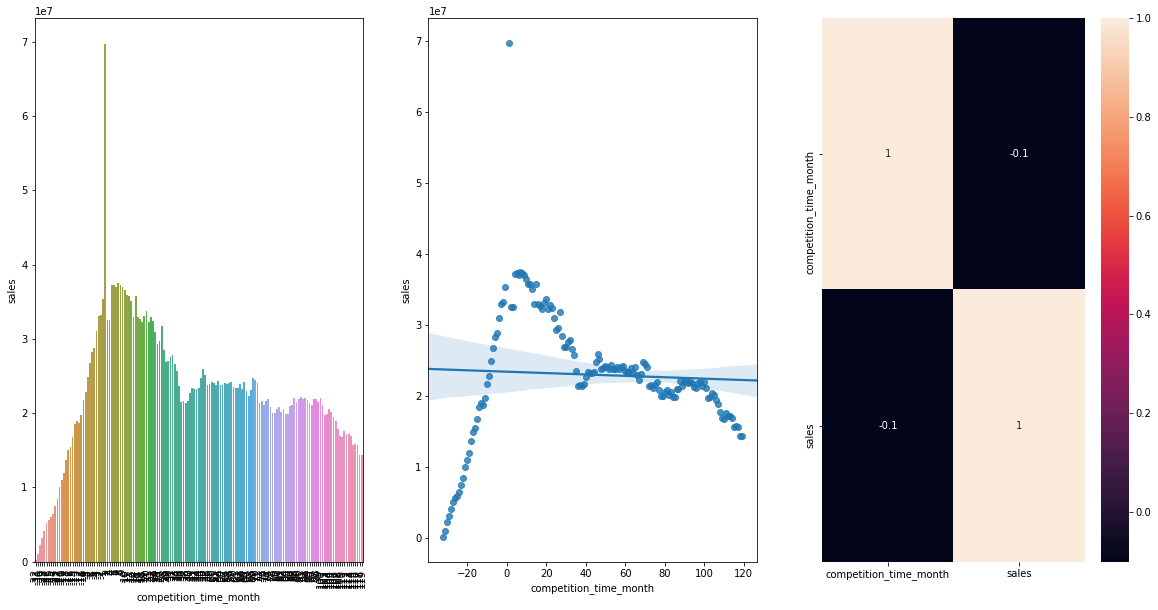

In [32]:
plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
df_aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
df_aux2 = df_aux1[(df_aux1['competition_time_month'] < 120 ) & ( df_aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=df_aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=df_aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( df_aux1.corr( method='pearson'), annot=True );

#### Hipótese 4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA!** Lojas com PROMOÇÕES ATIVAS POR MAIS TEMPO não VENDE MAIS depois de um certo periodo da promoção.

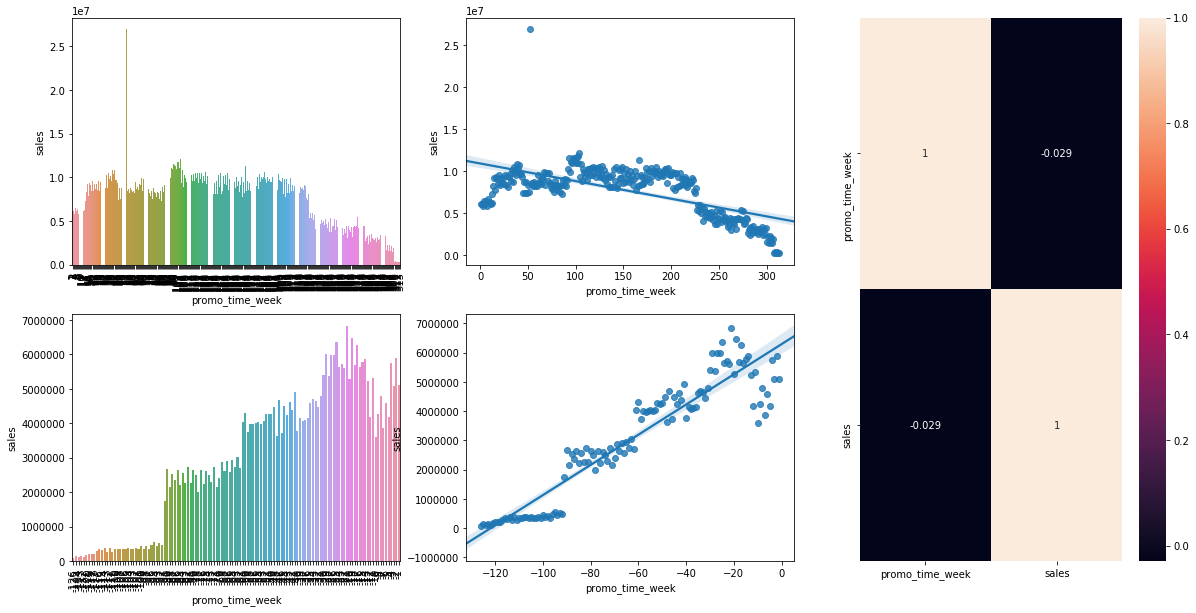

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


grid = plt.GridSpec( 2, 3 )

plt.figure(figsize=(20, 10))

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo extendido
sns.barplot(x='promo_time_week', y= 'sales', data = aux2);
plt.xticks(rotation =90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y= 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]  # promo normal
sns.barplot(x='promo_time_week', y= 'sales', data = aux3);
plt.xticks(rotation =90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y= 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True );

#### <s>Hipótese 5. Lojas com mais dias de promoção deveriam vender mais.</s>



#### Hipótese 6. Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA!** Lojas com PROMOÇÕES CONSECUTIVAS vendem MENOS

In [46]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index().sort_values(by='sales')

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


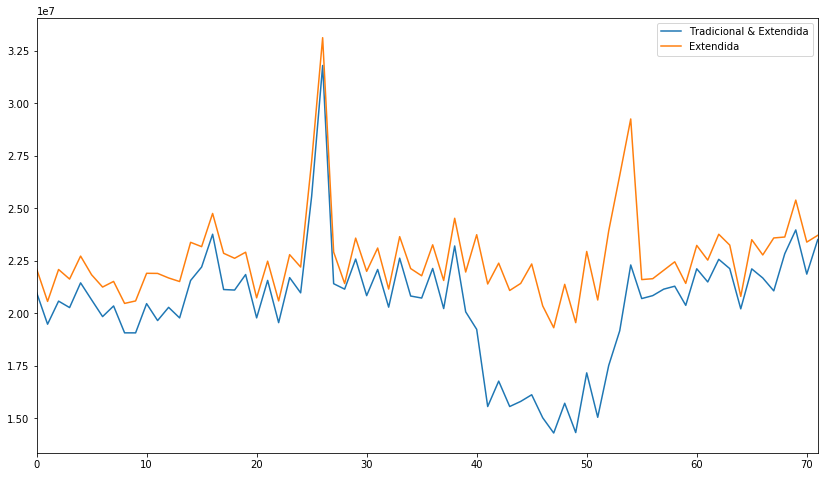

In [55]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(14,8))

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax,figsize=(14,8) )

ax.legend(labels=['Tradicional & Extendida','Extendida'])

#### Hipótese 7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA!** Lojas no Natal VENDEM MENOS.

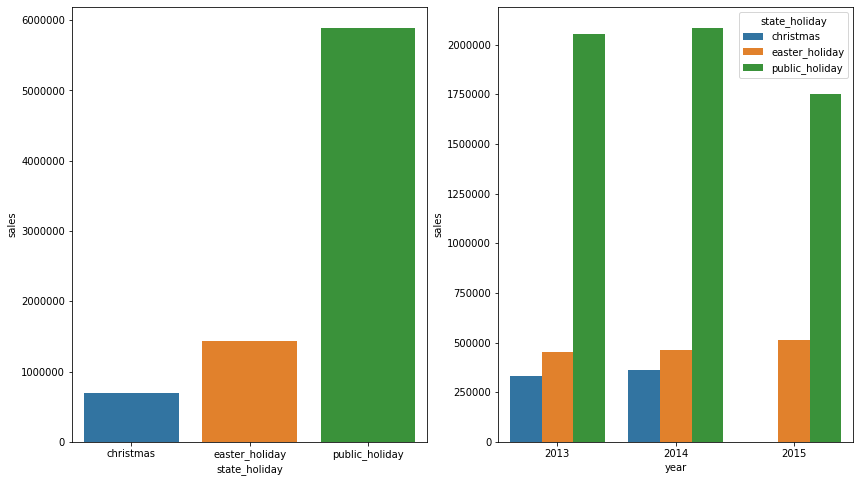

In [71]:

plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!= 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue= 'state_holiday', data = aux2)


#### Hipótese 8. Lojas deveriam vender mais ao longo dos anos.

**FALSA!** Lojas VENDEM MENOS ao longo dos anos.

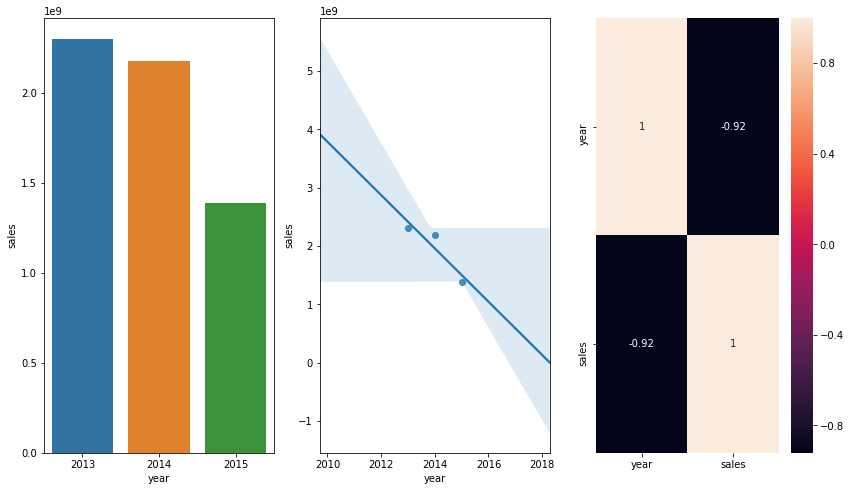

In [77]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data= aux);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data= aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### Hipótese 9. Lojas deveriam vender mais no segundo semestre do ano.

**FALSA!** Lojas VENDEM MENOS no segundo semestre do ano.

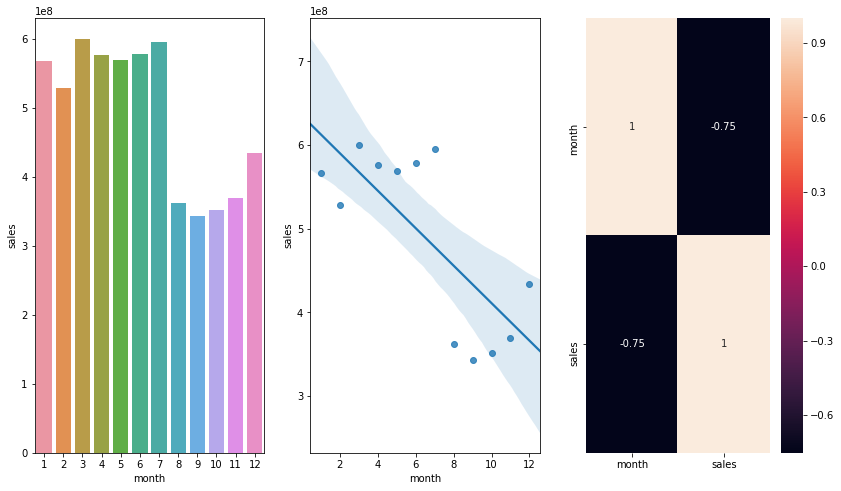

In [78]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data= aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### Hipótese 10. Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRA!** Lojas VENDEM MAIS depois do dia 10.

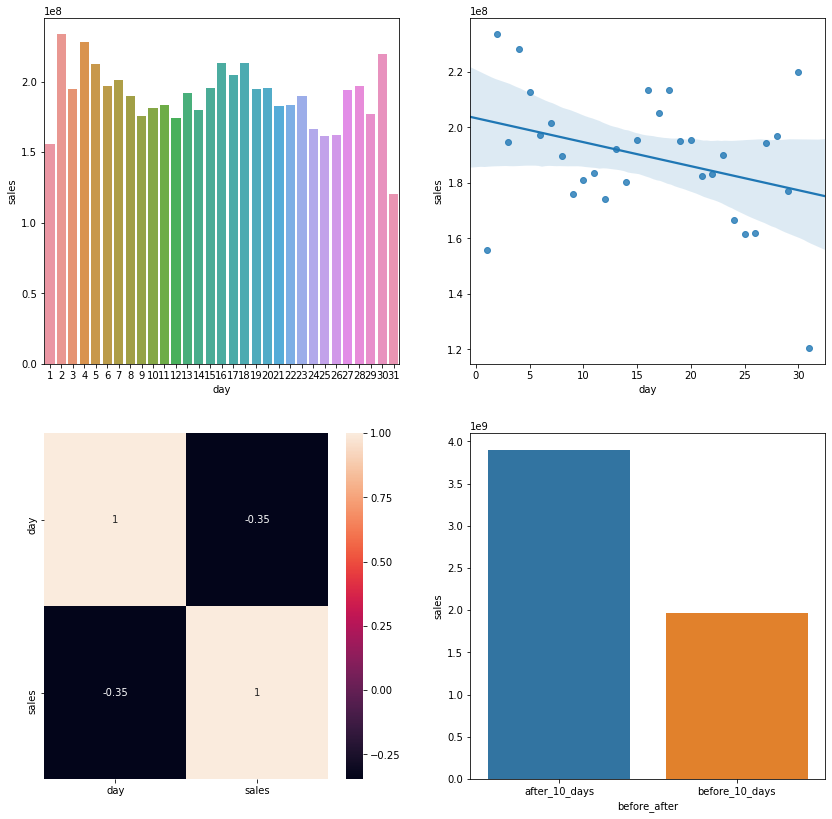

In [89]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data= aux);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data= aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#filtro antes e depois do dia 10
aux['before_after']= aux['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux1 = aux[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux1);

#### Hipótese 11. Lojas deveriam vender menos aos finais de semana.

**VERDADEIRA!** Lojas VENDEM MENOS nos finais de semana.

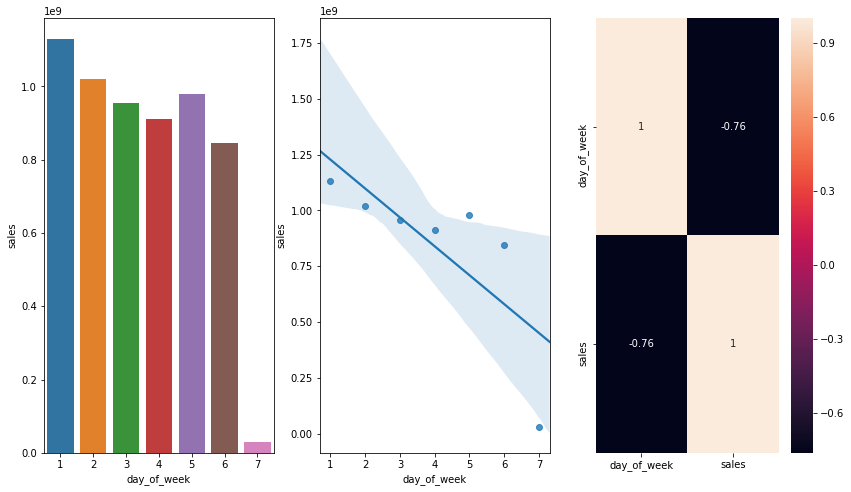

In [90]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(14,8))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data= aux);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data= aux);

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### Hipótese 12. Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRA!** Lojas VENDEM MENOS nos periodos esco

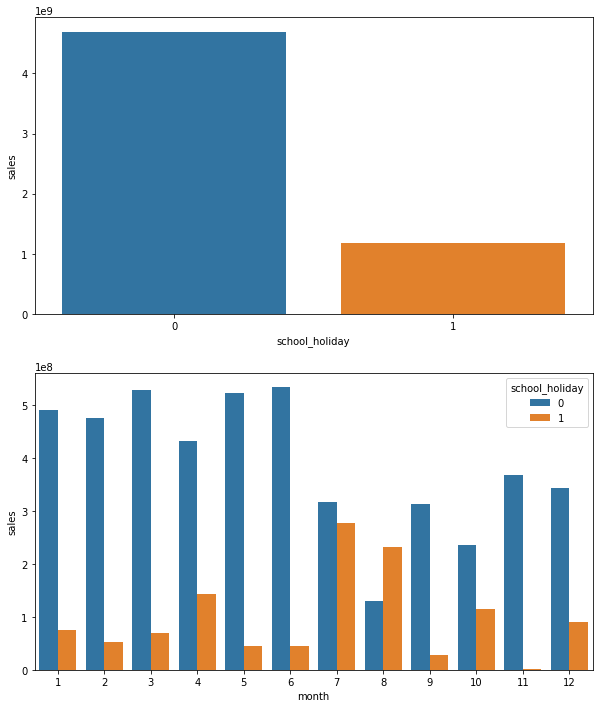

In [96]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data = aux)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue ='school_holiday', data = aux2)


### 4.3 Análise Multivariada